# Politics classifier with ANN as baseline

In [25]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [26]:
df = pd.read_csv("dataset_finalized.csv",index_col=0)
df

,text,classification
0,Opinion | Glenn Youngkin’s No-Guilt History of...,left
1,Opinion | Glenn Youngkin’s No-Guilt History of...,left
2,"Won't be long, and they'll be banning the teac...",left
3,Federal Standards for education are needed. Wh...,left
4,They don't want to be made uncomfortable by th...,left
...,...,...
28121,Remember when talking about covid or the Biden...,right
28122,When the science changes to match the politica...,right
28123,I personally can't wait for covid to inevitabl...,right
28124,I keep seeing people say this but what changed...,right


In [27]:
df['classification'] = df['classification'].map({'left': 0, 'right': 1})


In [28]:
tonkenized_df = pd.DataFrame()
tokenizer = ttd.utils.get_tokenizer("toktok")
for index , row in df.iterrows(): 
    js = {
        "text": tokenizer(row["text"]),
        "classification": row["classification"]
    }
    tonkenized_df = tonkenized_df.append(js,ignore_index = True)

tonkenized_df

,text,classification
0,"[Opinion, &#124;, Glenn, Youngkin, ’, s, No-Gu...",0.0
1,"[Opinion, &#124;, Glenn, Youngkin, ’, s, No-Gu...",0.0
2,"[Won, ', t, be, long, ,, and, they, ', ll, be,...",0.0
3,"[Federal, Standards, for, education, are, need...",0.0
4,"[They, don, ', t, want, to, be, made, uncomfor...",0.0
...,...,...
28121,"[Remember, when, talking, about, covid, or, th...",1.0
28122,"[When, the, science, changes, to, match, the, ...",1.0
28123,"[I, personally, can, ', t, wait, for, covid, t...",1.0
28124,"[I, keep, seeing, people, say, this, but, what...",1.0


In [41]:
vec  = GloVe("twitter.27B",dim=25)
vec[['here', 'is', 'an', 'example']]

TypeError: unhashable type: 'list'

In [30]:
X = torch.zeros(len(tonkenized_df), 25)

for index , row in df.iterrows(): 
    ret = vec.get_vecs_by_tokens(tonkenized_df.iloc[index]["text"], lower_case_backup=True)
    X[index, :] = torch.mean(ret, dim=0)

In [31]:
Y = tonkenized_df["classification"]
Y = torch.from_numpy(Y.to_numpy()).reshape(-1,1)
Y = Y.float()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=49)
model = nn.Sequential(
    nn.Linear(X_train.size(1),20),
    nn.ReLU(),
    nn.Linear(20,20),
    nn.ReLU(),
    nn.Linear(20,1),
    nn.Sigmoid()
)


In [33]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)

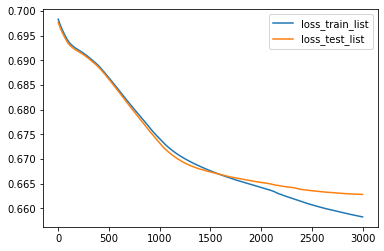

In [34]:

num_epochs = 3000 #model overfits after 3000 epochs
loss_train_list = np.zeros(num_epochs)
loss_test_list = np.zeros(num_epochs)
acc_train_list = np.zeros(num_epochs)
acc_test_list = np.zeros(num_epochs)
for i in range(num_epochs):
    optimizer.zero_grad()
    y_result = model(X_train)
    loss_train = criterion(y_result,y_train)
    loss_train_list[i] = loss_train.item()

    train_acc = np.mean(np.round(y_result.detach().numpy()) == np.round(y_train.detach().numpy()))
    acc_train_list[i] = train_acc
    
    y_result = model(X_test)
    loss_test = criterion(y_result,y_test)
    loss_test_list[i] = loss_test.item()
    
    test_acc = np.mean(np.round(y_result.detach().numpy()) == np.round(y_test.detach().numpy()))
    acc_test_list[i] = test_acc

    loss_train.backward()
    optimizer.step()

plt.plot(loss_train_list, label = "loss_train_list")
plt.plot(loss_test_list, label = "loss_test_list")
plt.legend()
plt.show()

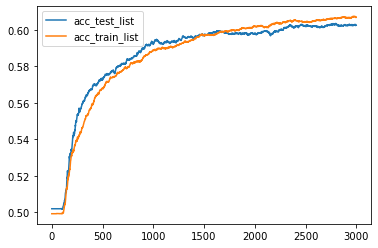

In [35]:
plt.plot(acc_test_list, label = "acc_test_list")
plt.plot(acc_train_list, label = "acc_train_list")
plt.legend()
plt.show()

In [36]:
def politic_classifier(text):
    text = tokenizer(text)
    text = vec.get_vecs_by_tokens(text, lower_case_backup=True)
    text = torch.mean(text,dim=0)
    output = model(text)
    print(output)
    if output.detach().item() < 0.5:
        print("The text is written by a leftist")
    else:
        print("The text is written by a rightist")

In [37]:
politic_classifier("Republican propaganda has literally melted his brain into a facade of what it used to be.") #text from r/politics which is not in the dataset


tensor([0.5191], grad_fn=<SigmoidBackward0>)
The text is written by a rightist


In [38]:
y_train.mean()

tensor(0.5009)

In [39]:
politic_classifier("As a conservative i think that")

tensor([0.5533], grad_fn=<SigmoidBackward0>)
The text is written by a rightist
